# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [33]:
import numpy as np
import pandas as pd
#import arch as arch_model
from pathlib import Path
%matplotlib inline

In [34]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

yenfutures_copy = yen_futures.copy()

In [35]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

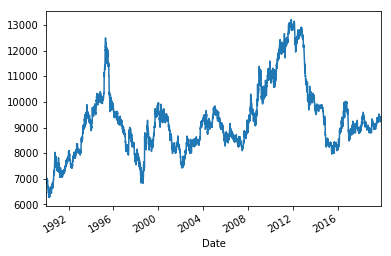

In [36]:
# Plot just the "Settle" column from the dataframe:
# YOUR CODE HERE!
yen_futures.Settle.plot()

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [37]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
# YOUR CODE HERE!
yen_futures_noise, yen_futures_trend = sm.tsa.filters.hpfilter(yen_futures["Settle"])


In [38]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
# YOUR CODE HERE!
yen_futures_Settle= yen_futures.loc["1990-01-01":, :]
#yen_futures_Settle.rename(columns={'':'Settle'}, inplace=True)
yen_futures_Settle = yen_futures_Settle['Settle'].copy()
yen_futures_Settle.head()
joined_df = pd.concat([yen_futures_Settle,yen_futures_noise, yen_futures_trend ], axis ='columns', join='inner')
joined_df.tail()

,Settle,Settle_cycle,Settle_trend
Date,,,
2019-10-09,9338.0,24.939247,9313.060753
2019-10-10,9303.5,-5.868559,9309.368559
2019-10-11,9251.0,-54.454594,9305.454594
2019-10-14,9265.0,-36.423060,9301.423060
2019-10-15,9221.5,-75.844123,9297.344123


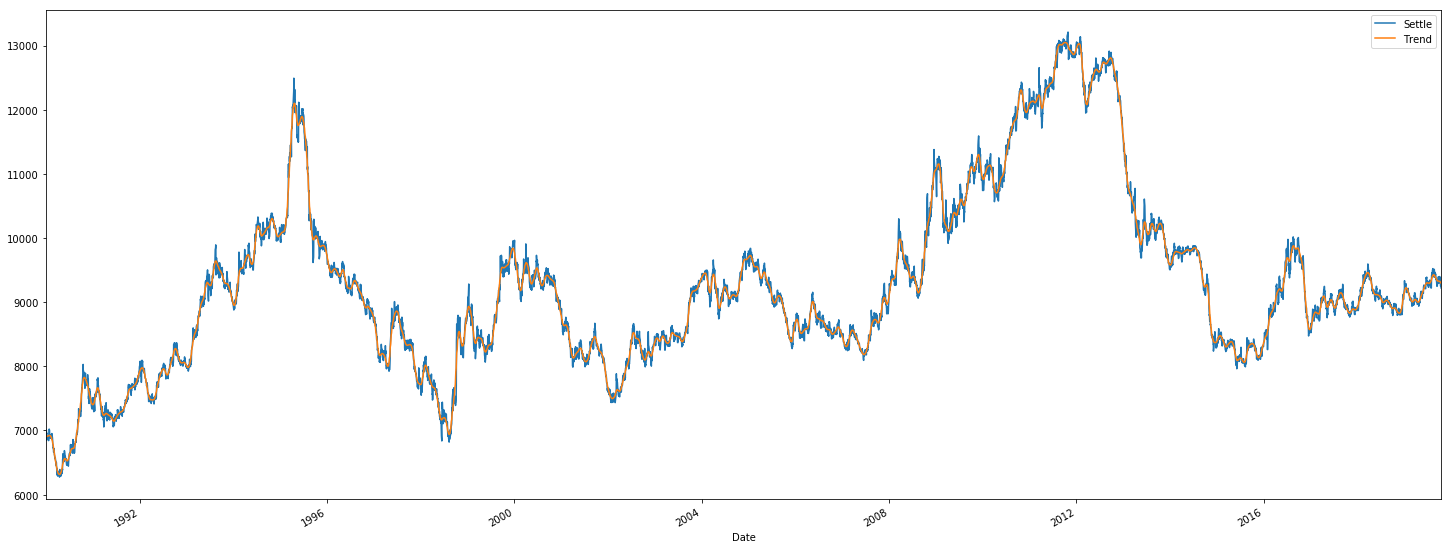

In [39]:
# Plot the Settle Price vs. the Trend for 2015 to the present
ax =yen_futures["Settle"].plot(figsize=(25,10))
yen_futures_trend.plot(ax=ax)

# Set the legend of the figure
ax.legend(["Settle", "Trend"]);


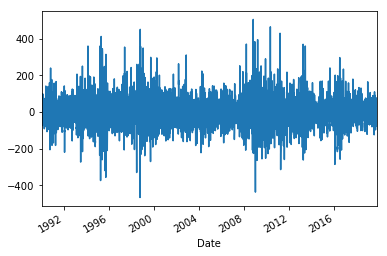

In [40]:
# Plot the Settle Noise
# YOUR CODE HERE!
yen_futures_noise.plot()

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [41]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [42]:
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
# YOUR CODE HERE!
model_arma = ARMA(returns.values, order=(2, 1))

# Fit the model and assign it to a variable called results
# YOUR CODE HERE!
result_arma = model_arma.fit()


C:\Users\kedar\anaconda3\envs\pyvizenv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [43]:
# Output model summary results:
# YOUR CODE HERE!
result_arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Tue, 09 Feb 2021   AIC                          15798.142
Time:                        19:33:44   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.804      0.422      -0.009       0.022
ar.L1.y       -0.3062      1.277     -0.240      0.811      -2.810       2.197
ar.L2.y       -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.y        0.2946      1.277      0.231      0.818      -2.209       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3352           +0.0000j            3.3352            0.5000
AR.2         -157.2096           +0.0000j          157.2096            0.5000
MA.1           -3.3941           +0.0000j            3.3941            0.5000
-----------------------------------------------------------------------------
"""

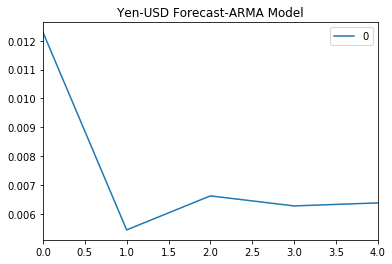

In [17]:
# Plot the 5 Day Returns Forecast
# YOUR CODE HERE!
pd.DataFrame(result_arma.forecast(steps=5)[0]).plot(title="Yen-USD Forecast-ARMA Model")

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [18]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
# YOUR CODE HERE!
model_arima = ARIMA(yen_futures.Settle.values, order=(1, 1, 1))

# Fit the model
# YOUR CODE HERE!
results_arima = model_arima.fit()

C:\Users\kedar\anaconda3\envs\pyvizenv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [19]:
# Output model summary results:
results_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 7514
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -41945.752
Method:                       css-mle   S.D. of innovations             64.290
Date:                Tue, 09 Feb 2021   AIC                          83899.504
Time:                        18:24:44   BIC                          83927.202
Sample:                             1   HQIC                         83909.014
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3161      0.705      0.448      0.654      -1.066       1.699
ar.L1.D.y      0.6785      0.174      3.904      0.000       0.338       1.019
ma.L1.D.y     -0.6943      0.170     -4.080      0.000      -1.028      -0.361
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4737           +0.0000j            1.4737            0.0000
MA.1            1.4403           +0.0000j            1.4403            0.0000
-----------------------------------------------------------------------------
"""

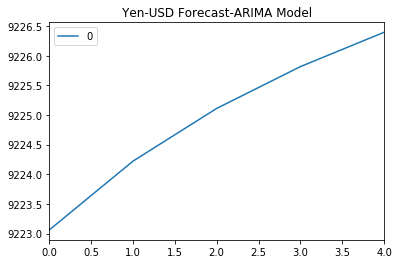

In [20]:
# Plot the 5 Day Price Forecast
# YOUR CODE HERE!
pd.DataFrame(results_arima.forecast(steps=5)[0]).plot(title="Yen-USD Forecast-ARIMA Model")

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [21]:
from arch import arch_model 

In [ ]:
# Estimate a GARCH model:
# YOUR CODE HERE!
model_garch = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=2)

# Fit the model
# YOUR CODE HERE!
results_garch = model_garch.fit(disp="off")

In [18]:
# Summarize the model results
# YOUR CODE HERE!
results_garch.summary()

NameError: name 'results_garch' is not defined

In [19]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [20]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
# YOUR CODE HERE!
forecasts = res.forecast(start=last_day, horizon=forecast_horizon)
forecasts

NameError: name 'res' is not defined

In [21]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

NameError: name 'forecasts' is not defined

In [22]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

NameError: name 'intermediate' is not defined

In [23]:
# Plot the final forecast
# YOUR CODE HERE!
final.plot()

NameError: name 'final' is not defined

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?

The p-values of the ARMA model are pretty high. ON the contrary, the  AIC And BIC values are low as compared to those for the ARIMA models
The p-values for the ARIMA model are almost zero. BUt the AIC and BIC values are pretty high. 
FOr the yen, the ARMA and ARIMA models are not aligned.
I am not confident of using either model for trading. 


In [ ]:
Give